In [22]:
%pylab inline
import xcml
import siestah2o as h2o
import pickle
from mbpol_calculator import MbpolCalculator, reconnect_monomers
from ase import Atoms
import siesta_utils.grid as siesta

Populating the interactive namespace from numpy and matplotlib


In [23]:
feat_getter = h2o.DescriptorGetter()

In [24]:
coords = xcml.find_coords('../test_run/siesta/H2O.out')

In [25]:
forces_siesta = xcml.find_forces('../test_run/siesta/H2O.out')

In [26]:
features = feat_getter.get_features(coords)

In [29]:
siesta.get_data_bin('H2O.RHOXC');

In [30]:
krr_O = pickle.load(open('/gpfs/home/smdick/exchange_ml/models/final/krr_Oxygen_descr', 'rb'))
krr_H = pickle.load(open('/gpfs/home/smdick/exchange_ml/models/final/krr_Hydrogen_descr', 'rb'))
krr_O_dx = pickle.load(open('/gpfs/home/smdick/exchange_ml/models/final/krr_dx_O_descriptors', 'rb'))
krr_H_dx = pickle.load(open('/gpfs/home/smdick/exchange_ml/models/final/krr_dx_H_descriptors', 'rb'))
nn = xcml.load_network('/gpfs/home/smdick/exchange_ml/models/final/nn_mulliken_descriptors_dz/')

In [10]:
atoms = Atoms('128H2O')

atoms.set_positions(coords.reshape(-1,3))
atoms.set_pbc(True)
atoms.set_cell([15.646,15.646,15.646])

atoms = reconnect_monomers(atoms)

atoms.set_calculator(MbpolCalculator(atoms))

atoms.get_forces()

In [33]:
coords = xcml.fold_back_coords(coords, siesta)

force_corr = xcml.use_force_model(features[0].reshape(-1,34), krr_O, krr_H, 18,8, glob_cs = True, coords = coords).reshape(-1,3)
force_corr_dz = xcml.use_force_model_fd(features[0].reshape(-1,34), krr_O_dx, krr_H_dx,nn, 18,8, glob_cs = True, coords=coords, direction_factor = 1e4 )

Sharing scaler with species O
Sharing scaler with species H
Sharing scaler with species O
Sharing scaler with species H


In [34]:
forces_siesta 

array([[-0.347306, -0.350034,  0.725992],
       [ 0.368763,  0.772378, -0.199059],
       [ 0.131488, -0.327379, -0.560091],
       ...,
       [-0.404571, -0.185278,  0.895324],
       [ 0.210861,  0.72731 , -0.171502],
       [ 0.145693,  0.013669, -0.663791]])

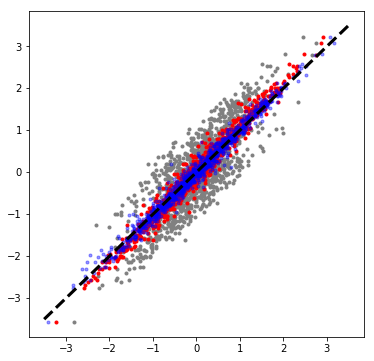

In [59]:
figsize(6,6)
plot(forces_siesta, atoms.get_forces(), ls = '', marker = '.', color = 'grey')
plot(forces_siesta - force_corr_dz.reshape(-1,3), atoms.get_forces(), ls = '', marker = '.', color = 'red')
plot(forces_siesta - force_corr, atoms.get_forces(), ls = '', marker = '.', color = 'blue', alpha = 0.4)
plot([-3.5,3.5],[-3.5,3.5], color = 'black', ls ='--', lw = 3.1)

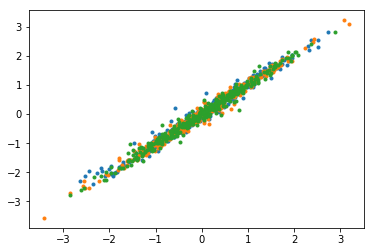

In [36]:
plot(forces_siesta - force_corr, atoms.get_forces(), ls = '', marker = '.')

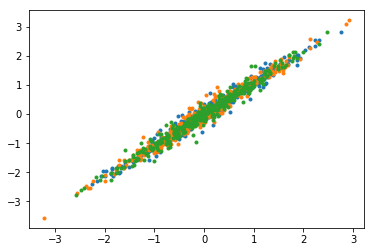

In [37]:
plot(forces_siesta - force_corr_dz.reshape(-1,3), atoms.get_forces(), ls = '', marker = '.')

In [47]:
(np.mean(np.abs((forces_siesta - atoms.get_forces())**1)))

0.47894036203567175

In [48]:
(np.mean(np.abs((forces_siesta - force_corr - atoms.get_forces())**1)))

0.09664028334504986

In [49]:
(np.mean(np.abs((forces_siesta - force_corr_dz.reshape(-1,3) - atoms.get_forces())**1)))

0.13322958297086634

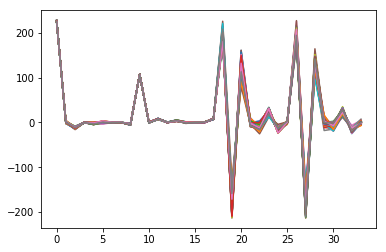

In [82]:
plot(features[0].reshape(-1,34).T);